In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 105.6 MB/s eta 0:00:00


In [3]:
# -*- coding: utf-8 -*-
# robot_news_rag.py
# 한국/일본 로봇뉴스 RAG 인덱스 + 간단 QA 파이프라인

import os
import json
import numpy as np
import pandas as pd
from typing import List, Dict, Any

import faiss
from sentence_transformers import SentenceTransformer

from openai import OpenAI

In [4]:
# ===========================
# 0. 경로 & 기본 설정
# ===========================
DRIVE_BASE = "/content/drive/MyDrive"

ROBOT_BASE = os.path.join(DRIVE_BASE, "NLP", "robot_news")
INDEX_DIR  = os.path.join(DRIVE_BASE, "NLP", "index_rag")

CHUNKS_FILE = os.path.join(ROBOT_BASE, "chunks_koja.csv")   # ko+ja chunk 통합 파일 기준

FAISS_INDEX_PATH = os.path.join(INDEX_DIR, "faiss.index")
META_PATH        = os.path.join(INDEX_DIR, "meta.parquet")

EMBED_MODEL_NAME = "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
EMBED_DIM = 768   # 모델에 맞게 수정 (multilingual-mpnet-base-v2는 768)


# ===========================
# 1. 유틸 함수
# ===========================
def ensure_dirs():
    os.makedirs(INDEX_DIR, exist_ok=True)


def load_chunks(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)

    # 0) 중복 컬럼 제거 (방어용)
    df = df.loc[:, ~df.columns.duplicated()].copy()

    # 1) doc_id 충돌 해결 → doc_id_short만 사용
    if "doc_id" in df.columns and "doc_id_short" in df.columns:
        print("[INFO] Removing doc_id (keeping doc_id_short)")
        df = df.drop(columns=["doc_id"])

    # 2) 텍스트 컬럼 찾기
    text_candidates = ["chunk_text", "text", "content", "content_norm"]
    text_col = next((c for c in text_candidates if c in df.columns), None)
    if text_col is None:
        raise ValueError("텍스트 컬럼 없음")

    # 3) doc_id 컬럼 재설정 (doc_id_short 사용)
    if "doc_id_short" in df.columns:
        df.rename(columns={"doc_id_short": "doc_id"}, inplace=True)
    else:
        df["doc_id"] = range(len(df))

    # 4) language 기본값
    if "language" not in df.columns:
        df["language"] = "ko"

    # 5) rename 정리
    df.rename(columns={text_col: "chunk_text"}, inplace=True)

    # 최종 중복 제거 (rename 이후)
    df = df.loc[:, ~df.columns.duplicated()].copy()

    return df

def normalize_embeddings(x: np.ndarray) -> np.ndarray:
    """
    L2 정규화하여 inner product = cosine similarity처럼 쓰도록 함.
    """
    x = x.astype("float32")
    norms = np.linalg.norm(x, axis=1, keepdims=True) + 1e-12
    return x / norms


# ===========================
# 2. 인덱스 구축
# ===========================
def build_faiss_index(df_chunks: pd.DataFrame,
                      model_name: str = EMBED_MODEL_NAME,
                      batch_size: int = 128) -> faiss.Index:
    """
    SentenceTransformer로 chunk 텍스트를 임베딩하고,
    FAISS IndexFlatIP로 인덱스를 구축해 저장.
    """
    print("[INFO] Loading embedding model:", model_name)
    model = SentenceTransformer(model_name)

    texts = df_chunks["chunk_text"].astype(str).tolist()
    n = len(texts)
    print(f"[INFO] #chunks = {n}")

    all_embeds = np.zeros((n, EMBED_DIM), dtype="float32")

    for start in range(0, n, batch_size):
        end = min(start + batch_size, n)
        batch = texts[start:end]
        emb = model.encode(batch, show_progress_bar=False)
        all_embeds[start:end] = emb

        if (start // batch_size) % 10 == 0:
            print(f"[ENCODING] {end}/{n}")

    all_embeds = normalize_embeddings(all_embeds)

    # FAISS index (Inner Product)
    index = faiss.IndexFlatIP(EMBED_DIM)
    index.add(all_embeds)
    print("[INFO] FAISS index built. ntotal =", index.ntotal)

    # 저장
    faiss.write_index(index, FAISS_INDEX_PATH)
    df_chunks.to_parquet(META_PATH, index=False)
    print("[INFO] Saved index to:", FAISS_INDEX_PATH)
    print("[INFO] Saved metadata to:", META_PATH)

    return index


def load_faiss_index() -> tuple[faiss.Index, pd.DataFrame]:
    """
    이미 저장된 인덱스와 메타데이터를 로드.
    """
    if not (os.path.exists(FAISS_INDEX_PATH) and os.path.exists(META_PATH)):
        raise FileNotFoundError("인덱스/메타 파일이 존재하지 않습니다. 먼저 build를 수행하세요.")

    index = faiss.read_index(FAISS_INDEX_PATH)
    meta = pd.read_parquet(META_PATH)

    print("[INFO] Loaded FAISS index:", FAISS_INDEX_PATH)
    print("[INFO] Loaded meta:", META_PATH, "| rows:", len(meta))

    return index, meta


# ===========================
# 3. RAG 검색 + LLM QA
# ===========================
class RobotNewsRAG:
    def __init__(self,
                 embed_model_name: str = EMBED_MODEL_NAME,
                 openai_model: str = "gpt-4.1-mini"):
        self.embed_model_name = embed_model_name
        self.embed_model = SentenceTransformer(embed_model_name)

        # OpenAI client
        self.client = OpenAI()
        self.openai_model = openai_model

        self.index, self.meta = load_faiss_index()

    def embed_query(self, query: str) -> np.ndarray:
        q = self.embed_model.encode([query], show_progress_bar=False)
        q = normalize_embeddings(q)
        return q

    def retrieve(self, query: str, top_k: int = 5) -> pd.DataFrame:
        """
        쿼리 임베딩 → FAISS 검색 → 관련 chunk 상위 k개 리턴
        """
        q = self.embed_query(query)
        scores, idxs = self.index.search(q, top_k)  # (1, k)
        idxs = idxs[0]
        scores = scores[0]

        df_hits = self.meta.iloc[idxs].copy()
        df_hits["score"] = scores
        return df_hits

    def build_prompt(self, query: str, contexts: List[str]) -> str:
        """
        검색된 chunk들을 evidence로 넣어서 프롬프트 생성.
        """
        ctx_text = ""
        for i, c in enumerate(contexts, 1):
            ctx_text += f"[문서 {i}]\n{c}\n\n"

        system_msg = (
            "너는 한국과 일본의 로봇 산업/기술 뉴스를 잘 아는 분석가야. "
            "아래에 제공된 기사 조각(evidence)만을 근거로 질문에 답해줘. "
            "절대로 evidence에 없는 내용을 새로 만들어내지 마. "
            "추론, 상식적 추측, 외부 지식 사용 금지. "
            "evidence 안에서 직접적으로 확인 가능한 내용만 사용해. "
            "만약 evidence 안에 답이 없다면 '제공된 근거에서 확인할 수 없습니다'라고 답해."
            )

        user_msg = (
            f"질문:\n{query}\n\n"
            f"다음은 검색된 관련 기사 조각들이야. 한국어/일본어가 섞여 있을 수 있어.\n\n"
            f"{ctx_text}\n"
            "위 내용만을 근거로, 한국어로 간결하고 명확하게 답변해줘."
        )

        return system_msg, user_msg

    def answer(self, query: str, top_k: int = 5) -> Dict[str, Any]:
        """
        1) retrieve
        2) GPT-4.1-mini로 답변 생성
        3) 검색 evidence와 함께 리턴
        """
        hits = self.retrieve(query, top_k=top_k)

        contexts = hits["chunk_text"].astype(str).tolist()
        system_msg, user_msg = self.build_prompt(query, contexts)

        resp = self.client.chat.completions.create(
            model=self.openai_model,
            messages=[
                {"role": "system", "content": system_msg},
                {"role": "user", "content": user_msg},
            ],
            temperature=0.2,
        )

        answer = resp.choices[0].message.content

        return {
            "query": query,
            "answer": answer,
            "hits": hits
        }



In [6]:
import os
os.environ["OPENAI_API_KEY"] = "sk-YOUR API KEY"

In [7]:
# RAG 인스턴스 생성 (인덱스는 이미 빌드된 상태여야 함)
rag = RobotNewsRAG()

def ask(query, top_k=5):
    result = rag.answer(query, top_k=top_k)
    print("\n====================")
    print("QUERY:")
    print(query)
    print("\nANSWER:")
    print(result["answer"])
    print("\nTOP HITS (Preview):")
    for i, row in result["hits"].head(3).iterrows():
        print("-----")
        print(f"score={row['score']:.3f}, lang={row.get('language','?')}, doc={row.get('doc_id','?')}")
        print(row['chunk_text'][:200].replace("\n"," ") + "...")
    print("====================")

[INFO] Loaded FAISS index: /content/drive/MyDrive/NLP/index_rag/faiss.index
[INFO] Loaded meta: /content/drive/MyDrive/NLP/index_rag/meta.parquet | rows: 18428


RAGAS 평가

In [8]:
# -*- coding: utf-8 -*-
import pandas as pd
import json
from tqdm import tqdm

# 1) 질문셋 로드
questions_df = pd.read_csv("/content/drive/MyDrive/NLP/robot_news/eval_questions.csv")

# 2) RAG 객체 로드
rag = RobotNewsRAG()

# 3) RAG 답변 생성
records = []
for idx, row in tqdm(questions_df.iterrows(), total=len(questions_df)):
    q = row["question"]
    res = rag.answer(q, top_k=5)

    records.append({
        "question": q,
        "answer": res["answer"],
        "contexts": res["hits"]["chunk_text"].tolist(),   # list 그대로 넣기
        "language": row.get("language", ""),
        "category": row.get("category", "")
    })

df_eval = pd.DataFrame(records)
df_eval.to_json(
    "/content/drive/MyDrive/NLP/robot_news/eval_raw.json",
    orient="records",
    force_ascii=False,
    indent=2
)
print("[INFO] eval_raw.json saved.")


[INFO] Loaded FAISS index: /content/drive/MyDrive/NLP/index_rag/faiss.index
[INFO] Loaded meta: /content/drive/MyDrive/NLP/index_rag/meta.parquet | rows: 18428


100%|██████████| 20/20 [00:46<00:00,  2.34s/it]


[INFO] eval_raw.json saved.


In [ ]:
!pip install ragas==0.1.9 datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.1/86.1 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 7.3 MB/s eta 0:00:00
  Attempting uninstall: ragas
    Found existing installation: ragas 0.3.9
    Uninstalling ragas-0.3.9:
      Successfully uninstalled ragas-0.3.9


In [2]:
!pip -q install -U "ragas==0.1.21" "langchain==0.2.16" "langchain-core==0.2.38" "pydantic==2.7.4"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.4/109.4 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.4/396.4 kB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.0/409.0 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 71.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 95.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.8/311.8 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 117.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/

런타임 재시작

In [1]:
import ragas
from ragas import evaluate
from ragas.metrics import (
    AnswerRelevancy,
    Faithfulness,
    ContextPrecision,
    ContextRecall
)
import json

In [2]:
import os
os.environ["OPENAI_API_KEY"] = "sk-YOUR API KEY"

청킹 하기

In [3]:
import pandas as pd
import nltk
from tqdm import tqdm

nltk.download('punkt')
nltk.download('punkt_tab')

BASE = "/content/drive/MyDrive/NLP/robot_news"

IN_KO = f"{BASE}/Ko_clean.csv"
IN_JA = f"{BASE}/Ja_clean.csv"

OUT_KO = f"{BASE}/chunks_ko.csv"
OUT_JA = f"{BASE}/chunks_ja.csv"
OUT_KOJA = f"{BASE}/chunks_koja.csv"


# ----- 문장 단위 청킹 함수 -----
def sentence_chunk(text, min_sent=3, max_sent=6):
    sents = nltk.sent_tokenize(text)

    chunks, cur = [], []
    for s in sents:
        cur.append(s)
        if len(cur) >= max_sent:
            chunks.append(" ".join(cur))
            cur = []
    if len(cur) >= min_sent:
        chunks.append(" ".join(cur))
    return chunks


# ----- 청킹 처리 -----
def build(df, lang):
    rows = []

    for _, row in tqdm(df.iterrows(), total=len(df)):
        doc_id = row["doc_id"]
        text = row["content"]

        if not isinstance(text, str) or len(text.strip()) == 0:
            continue

        for i, ch in enumerate(sentence_chunk(text)):
            rows.append({
                "doc_id": doc_id,
                "chunk_id": f"{doc_id}_{i}",
                "language": lang,
                "chunk_text": ch,
                "source": row.get("source", ""),
                "published_at": row.get("published_at", "")
            })
    return pd.DataFrame(rows)


# ----- 로드 -----
df_ko = pd.read_csv(IN_KO)
df_ja = pd.read_csv(IN_JA)

# ----- 청킹 -----
print("Chunking Korea...")
ko_chunks = build(df_ko, "ko")

print("Chunking Japan...")
ja_chunks = build(df_ja, "ja")

# ----- 저장 (덮어쓰기) -----
ko_chunks.to_csv(OUT_KO, index=False)
ja_chunks.to_csv(OUT_JA, index=False)

# ko + ja 병합본도 저장
pd.concat([ko_chunks, ja_chunks], ignore_index=True).to_csv(OUT_KOJA, index=False)

print("청킹 완료 및 기존 파일 덮어쓰기 완료")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Chunking Korea...


100%|██████████| 5143/5143 [00:02<00:00, 2365.68it/s]


Chunking Japan...


100%|██████████| 1691/1691 [00:00<00:00, 14925.34it/s]


청킹 완료 및 기존 파일 덮어쓰기 완료


Oepn AI Embedding + FAISS Indexing

In [4]:
# -*- coding: utf-8 -*-
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from openai import OpenAI
import faiss

# =========================
# 0) 경로 설정
# =========================
BASE = "/content/drive/MyDrive/NLP/robot_news"

CHUNKS_FILE = f"{BASE}/chunks_koja.csv"

EMB_DIR = f"{BASE}/embeddings"
META_PATH = f"{EMB_DIR}/meta.csv"
EMB_PATH = f"{EMB_DIR}/embeddings.npy"
FAISS_PATH = f"{BASE}/faiss.index"

os.makedirs(EMB_DIR, exist_ok=True)

# =========================
# 1) OpenAI client 준비
# =========================
client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])
MODEL = "text-embedding-3-small"


# =========================
# 2) 청킹 불러오기
# =========================
df = pd.read_csv(CHUNKS_FILE)

print(f"[INFO] Loaded chunks: {df.shape}")


# =========================
# 3) OpenAI 임베딩 생성
# =========================
def embed_batches(texts, batch_size=128):
    vectors = []

    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i + batch_size]

        response = client.embeddings.create(
            model=MODEL,
            input=batch
        )

        vecs = [item.embedding for item in response.data]
        vectors.extend(vecs)

    return np.array(vectors, dtype="float32")


print("[INFO] Generating embeddings...")
emb = embed_batches(df["chunk_text"].tolist())

print("[INFO] Embedding shape:", emb.shape)

# 저장
np.save(EMB_PATH, emb)
df.to_csv(META_PATH, index=False)


# =========================
# 4) FAISS 인덱스 구축
# =========================
dim = emb.shape[1]
index = faiss.IndexFlatL2(dim)

print("[INFO] Building FAISS index...")
index.add(emb)

faiss.write_index(index, FAISS_PATH)
print("[INFO] Saved FAISS index to:", FAISS_PATH)

print("임베딩 + 인덱싱 전체 프로세스 완료")


[INFO] Loaded chunks: (15112, 6)
[INFO] Generating embeddings...


100%|██████████| 119/119 [04:56<00:00,  2.49s/it]


[INFO] Embedding shape: (15112, 1536)
[INFO] Building FAISS index...
[INFO] Saved FAISS index to: /content/drive/MyDrive/NLP/robot_news/faiss.index
임베딩 + 인덱싱 전체 프로세스 완료


RAG 재실행

In [ ]:
from typing import List, Dict, Any
import os
os.environ["OPENAI_API_KEY"] = "sk-YOUR API KEY"

In [ ]:
# ======================================
# 0. 경로 & 기본 설정 (OpenAI 기반)
# ======================================
import os
import numpy as np
import pandas as pd
import faiss
from typing import List, Dict, Any
from openai import OpenAI

# 사용 경로를 robot_news로 맞춤
DRIVE_BASE = "/content/drive/MyDrive"
ROBOT_BASE = os.path.join(DRIVE_BASE, "NLP", "robot_news")

EMB_DIR = os.path.join(ROBOT_BASE, "embeddings")

FAISS_INDEX_PATH = os.path.join(ROBOT_BASE, "faiss.index")
META_PATH        = os.path.join(EMB_DIR, "meta.csv")
EMB_PATH         = os.path.join(EMB_DIR, "embeddings.npy")

OPENAI_EMBED_MODEL = "text-embedding-3-small"
OPENAI_CHAT_MODEL = "gpt-4.1-mini"


# ======================================
# 1. 로더 함수
# ======================================
def load_openai_index():
    if not (os.path.exists(FAISS_INDEX_PATH) and os.path.exists(META_PATH) and os.path.exists(EMB_PATH)):
        raise FileNotFoundError("필요한 인덱스/메타/임베딩 파일이 없음. 먼저 OpenAI 임베딩 구축을 실행하세요.")

    index = faiss.read_index(FAISS_INDEX_PATH)
    meta = pd.read_csv(META_PATH)

    print("[INFO] Loaded FAISS index:", FAISS_INDEX_PATH)
    print("[INFO] Loaded meta:", META_PATH, "| rows:", len(meta))

    return index, meta


# ======================================
# 2. OpenAI 임베딩 생성 함수
# ======================================
client = OpenAI()

def embed_query_openai(text: str):
    resp = client.embeddings.create(
        model=OPENAI_EMBED_MODEL,
        input=[text]
    )
    emb = np.array(resp.data[0].embedding, dtype="float32").reshape(1, -1)

    # normalize
    emb = emb / (np.linalg.norm(emb) + 1e-12)
    return emb


# ======================================
# 3. RAG 시스템 정의 (OpenAI 기반)
# ======================================
class RobotNewsRAG:
    def __init__(self):
        self.index, self.meta = load_openai_index()
        self.client = client

    def retrieve(self, query: str, top_k: int = 5):
        q_emb = embed_query_openai(query)
        scores, idxs = self.index.search(q_emb, top_k)

        scores = scores[0]
        idxs = idxs[0]

        hits = self.meta.iloc[idxs].copy()
        hits["score"] = scores
        return hits

    def build_prompt(self, query: str, contexts: List[str]):
        ctx_text = ""
        for i, c in enumerate(contexts, 1):
            ctx_text += f"[문서 {i}]\n{c}\n\n"

        system_msg = (
            "너는 한국과 일본의 로봇 산업/기술 뉴스를 잘 아는 분석가야. "
            "아래에 제공된 기사 조각(evidence)만을 근거로 질문에 답해줘. "
            "절대로 evidence에 없는 내용을 새로 만들어내지 마. "
            "추론, 상식적 추측, 외부 지식 사용 금지. "
            "evidence 안에서 직접적으로 확인 가능한 내용만 사용해. "
            "만약 evidence 안에 답이 없다면 '제공된 근거에서 확인할 수 없습니다'라고 답해."
            )

        user_msg = (
            f"질문:\n{query}\n\n"
            f"다음은 검색된 관련 기사 조각들이야:\n\n"
            f"{ctx_text}\n"
            "위 evidence만을 근거로 간결하게 답변해줘."
        )

        return system_msg, user_msg

    def answer(self, query: str, top_k: int = 5) -> Dict[str, Any]:
        hits = self.retrieve(query, top_k=top_k)
        ctxs = hits["chunk_text"].astype(str).tolist()

        system_msg, user_msg = self.build_prompt(query, ctxs)

        resp = self.client.chat.completions.create(
            model=OPENAI_CHAT_MODEL,
            messages=[
                {"role": "system", "content": system_msg},
                {"role": "user", "content": user_msg},
            ],
            temperature=0.2,
        )

        answer = resp.choices[0].message.content

        return {
            "query": query,
            "answer": answer,
            "hits": hits
        }

    def pretty_print(self, result):
        print("\n[QUERY]")
        print(result["query"])

        print("\n[ANSWER]")
        print(result["answer"])

        print("\n[TOP HITS]")
        for idx, row in result["hits"].head(3).iterrows():
            print("-----")
            print(f"score={row['score']:.3f}, lang={row['language']}, doc_id={row['doc_id']}")
            preview = row["chunk_text"][:280].replace("\n", " ")
            print(preview + "...")


In [ ]:
rag = RobotNewsRAG()

[INFO] Loaded FAISS index: /content/drive/MyDrive/NLP/robot_news/faiss.index
[INFO] Loaded meta: /content/drive/MyDrive/NLP/robot_news/embeddings/meta.csv | rows: 15112


In [ ]:
query = "한국 물류 로봇 동향을 요약해줘."
result = rag.answer(query, top_k=5)

print("\n[QUERY]")
print(result["query"])

print("\n[ANSWER]")
print(result["answer"])

print("\n[TOP HITS]")
for idx, row in result["hits"].head(3).iterrows():
    print("-----")
    print(f"score={row['score']:.3f}, lang={row['language']}, doc_id={row['doc_id']}")
    txt = row["chunk_text"]
    print(txt[:280].replace("\n", " ") + "...")



[QUERY]
한국 물류 로봇 동향을 요약해줘.

[ANSWER]
한국 물류 로봇 동향은 다음과 같다. 롯데글로벌로지스는 로봇 물류자동화 전문 기업 필드로와 협력해 배송로봇을 활용한 ‘로봇 배송’ 서비스 상용화를 추진 중이며, 물류 자동화 사업 모델 설계와 테스트베드 운영을 진행하고 있다. 아시아나IDT는 카덱스램스타, 이삭엔지니어링과 협력해 로봇 물류 자동화 사업에 본격 진출하며, 제조·유통 분야 자동화 경험을 바탕으로 국내 대표 물류기업을 대상으로 차세대 통합 물류 시스템을 구축하고 있다. DLS는 AMR(자율이동로봇)과 창고제어시스템(WCS)을 개발해 대형 물류센터부터 마이크로풀필먼트센터까지 다양한 현장에 적용하며 물류 효율성을 극대화하고 있다. 레인보우로보틱스는 AI 기반 소프트웨어와 협동로봇, 이동형 양팔로봇, AMR, 휴머노이드 등 로봇 플랫폼을 개발해 CJ대한통운과 협업, AI 로봇 실증 테스트를 진행하며 주요 물류센터에 순차 적용할 계획이다. 전반적으로 AI와 로봇 기술 융합을 통한 스마트 물류 자동화와 배송로봇 상용화가 활발히 추진되고 있다.

[TOP HITS]
-----
score=0.991, lang=ko, doc_id=bec537e37ee80b3315b6cd4c2cc5d56a4201e75cf5d272a5b6d923b305f8bb6e
물류시장에서 스마트 물류 경쟁력 강화 ▲ 사진 왼쪽부터 김공수 롯데글로벌로지스 LIST본부장, 송영은 필드로 대표(사진=롯데글로벌로지스) 롯데글로벌로지스는 15일 로봇 물류자동화 전문 기업 필드로와 ‘로봇 및 물류자동화 비즈니스’에 협력하는 전략적 파트너십 구축을 위한 업무협약을 체결했다고 밝혔다. 이번 협약은 롯데글로벌로지스만의 차별화된 고객서비스 제공을 위한 물류 모빌리티 기술을 확보하고 관련 사업 모델을 개발하여, 물류시장에서의 스마트 물류 경쟁력을 강화하기 위하여 진행되었다. 롯데글로벌로지...
-----
score=1.034, lang=ko, doc_id=816e996e1efd5283dac58c3c

다시 정리해서 만들기

0. Imports

In [ ]:
import os
import numpy as np
import pandas as pd
import faiss
from tqdm import tqdm
from typing import List, Dict, Any
from openai import OpenAI

client = OpenAI()

1. 경로 설정

In [ ]:
DRIVE_BASE = "/content/drive/MyDrive"
ROBOT_BASE = os.path.join(DRIVE_BASE, "NLP", "robot_news")

CHUNKS_FILE = os.path.join(ROBOT_BASE, "chunks_koja.csv")
EMB_DIR = os.path.join(ROBOT_BASE, "embeddings")

os.makedirs(EMB_DIR, exist_ok=True)

META_PATH = os.path.join(EMB_DIR, "meta.csv")
EMB_PATH  = os.path.join(EMB_DIR, "embeddings.npy")
FAISS_INDEX_PATH = os.path.join(ROBOT_BASE, "faiss.index")

OPENAI_EMBED_MODEL = "text-embedding-3-small"
OPENAI_CHAT_MODEL  = "gpt-4.1-mini"


2. 임베딩 생성 함수

In [ ]:
def build_openai_embeddings(df: pd.DataFrame) -> np.ndarray:
    texts = df["chunk_text"].astype(str).tolist()
    all_emb = []

    print("[INFO] Building OpenAI embeddings...")
    for txt in tqdm(texts):
        resp = client.embeddings.create(
            model=OPENAI_EMBED_MODEL,
            input=[txt]
        )
        vec = np.array(resp.data[0].embedding, dtype="float32")
        vec /= np.linalg.norm(vec) + 1e-12
        all_emb.append(vec)

    all_emb = np.vstack(all_emb)

    np.save(EMB_PATH, all_emb)
    df.to_csv(META_PATH, index=False)
    print("[INFO] Embeddings + meta saved.")

    return all_emb


3. FAISS 인덱스 생성

In [ ]:
def build_faiss_index(embeddings: np.ndarray):
    dim = embeddings.shape[1]
    print("[INFO] Building FAISS index... dim =", dim)

    index = faiss.IndexFlatIP(dim)
    index.add(embeddings)

    faiss.write_index(index, FAISS_INDEX_PATH)
    print("[INFO] Saved index to:", FAISS_INDEX_PATH)

    return index


4. 인덱스 로드

In [ ]:
def load_faiss_index():
    meta = pd.read_csv(META_PATH)
    embeddings = np.load(EMB_PATH)
    index = faiss.read_index(FAISS_INDEX_PATH)

    print("[INFO] Loaded index & metadata.")
    return index, meta, embeddings


5. RAG 클래스

In [ ]:
class RobotNewsRAG:
    def __init__(self):
        self.index, self.meta, self.emb = load_faiss_index()
        self.client = client

    def embed_query(self, query: str) -> np.ndarray:
        resp = self.client.embeddings.create(
            model=OPENAI_EMBED_MODEL,
            input=[query]
        )
        vec = np.array(resp.data[0].embedding, dtype="float32")
        vec /= np.linalg.norm(vec) + 1e-12
        return vec.reshape(1, -1)

    def retrieve(self, query: str, top_k=5):
        q = self.embed_query(query)
        scores, idxs = self.index.search(q, top_k)

        hits = self.meta.iloc[idxs[0]].copy()
        hits["score"] = scores[0]
        return hits

    def build_prompt(self, query, ctxs):
        ctx_text = ""
        for i, c in enumerate(ctxs, 1):
            ctx_text += f"[문서 {i}]\n{c}\n\n"

        system_msg = (
            "너는 한국·일본 로봇 산업 뉴스 전문가야. "
            "evidence 안에 있는 내용만으로 답해야 한다."
            )

        user_msg = (
            f"질문:\n{query}\n\n"
            f"{ctx_text}\n"
            "위 evidence를 기반으로 아래 규칙에 따라 답변해:\n"
            "1) 반드시 1, 2, 3 번호를 붙여 항목별로 작성할 것.\n"
            "2) 각 항목은 한 문단으로 핵심 내용을 요약할 것.\n"
            "3) evidence에 없는 내용을 절대 추가하지 말 것.\n"
        )

        return system_msg, user_msg

    def answer(self, query: str, top_k=5):
        hits = self.retrieve(query, top_k)
        ctxs = hits["chunk_text"].tolist()

        system_msg, user_msg = self.build_prompt(query, ctxs)

        resp = self.client.chat.completions.create(
            model=OPENAI_CHAT_MODEL,
            messages=[
                {"role": "system", "content": system_msg},
                {"role": "user",    "content": user_msg},
            ],
            temperature=0.2,
        )

        answer = resp.choices[0].message.content

        return {"query": query, "answer": answer, "hits": hits}


6. ASK 함수

In [ ]:
def ask(query, top_k=5):
    result = rag.answer(query, top_k)

    print("\n====================")
    print("QUERY:")
    print(query)

    print("\nANSWER:")
    print(result["answer"])

    print("\nTOP HITS:")
    for i, row in result["hits"].head(3).iterrows():
        print("-----")
        print(f"score={row['score']:.3f}, lang={row['language']}, doc={row['doc_id']}")
        print(row['chunk_text'][:200].replace("\n"," ") + "...")

    print("====================")


7. 실행

In [ ]:
rag = RobotNewsRAG()
ask("한국에서 물류 로봇 관련 정책 동향을 알려줘.")


[INFO] Loaded index & metadata.

QUERY:
한국에서 물류 로봇 관련 정책 동향을 알려줘.

ANSWER:
1) 한국에서는 드론과 실외이동로봇을 이용한 배송이 가능하도록 법적 기반이 마련되었다. 국토교통부가 ‘생활물류서비스산업발전법’ 시행령을 개정해 드론은 항공사업법에 따른 초경량비행장치 사용사업 등록과 운행 요건을, 실외이동로봇은 지능형로봇법에 따른 운행안전 인증을 받도록 규정함으로써 배송 서비스에 드론과 실외이동로봇 활용이 법적으로 가능해졌다.

2) 실외이동로봇 산업 발전을 위해 법·제도적 보완과 표준 제정 작업이 빠르게 진행 중이며, 지능형로봇법 제정으로 운행안전인증을 받은 실외이동로봇에 보행자 지위를 부여하는 등 법적 근거가 강화되고 있다. 이를 통해 물류, 배달, 스마트시티 등 다양한 분야에서 실외이동로봇의 실용화와 시장 확대가 가속화될 전망이다.

3) 국내 기업들은 로봇 물류 자동화 사업에 본격 진출하고 있으며, 아시아나IDT는 카덱스램스타 및 이삭엔지니어링과 협력해 물류 자동화 솔루션을 확대하고 있다. 아시아나IDT는 롯데글로벌로지스, CJ대한통운 등 국내 주요 물류기업과 제조·유통 분야 자동화 시스템 구축 경험을 바탕으로 로봇 물류 자동화 사업을 추진 중이다.

TOP HITS:
-----
score=1.127, lang=ko, doc=22e00262fd3787630c39cb6578deef9efc7714136d5186b6a8a2daef7339bb64
드론과 실외이동로봇을 이용한 배송을 할 수 있도록 한 법적 기반이 마련됐다. 그동안 등록제로 운영해온 택배서비스업에 드론과 실외이동로봇은 요건에 맞지 않아 배송할 수 없었지만, 시행령 개정에 따라 법적 토대가 갖춰졌다. 국토교통부는 7일 국무회의에서 '생활물류서비스산업발전법' 시행령 개정안이 의결됐다고 밝혔다. 개정안에는 택배서비스사업에서 드론과 실외이동로...
-----
score=1.147, lang=ko, doc=7d3f7c802ccffdcc3f4aa4561ed62

In [ ]:
ask("일본 로봇 시장의 2024–2025년 주요 성장 분야는 어디야?")


QUERY:
일본 로봇 시장의 2024–2025년 주요 성장 분야는 어디야?

ANSWER:
1) 일본 로봇 시장의 2024–2025년 주요 성장 분야는 고정밀이 요구되는 전자 및 자동차 산업으로, 특히 중부 지역에서 반도체 및 전기차(EV) 제조용 로봇 도입이 크게 증가하고 있다. 정부의 ‘소사이어티 5.0’ 구상과 문샷형 연구개발 제도 등 정책적 지원도 로봇 산업 발전을 촉진하는 동력으로 작용하고 있다.

2) AI, 머신 비전, IoT 통합 등 혁신 기술이 로봇 능력을 향상시키며, 산업용 로봇팔, 자율이동로봇(AMR), 풀스택 개발 솔루션 등 지능형 제조 AI 로봇 분야가 성장하고 있다. 일본의 주요 로봇 제조 기업들이 AI 기반 로봇 공장 설비 응용 솔루션을 구축하며 시장을 주도하고 있다.

3) 자동차 산업의 구조조정과 대체 파워트레인 대응을 위한 로봇 기술 수요가 지속적으로 증가하고 있으며, 헬스케어 분야의 로봇 도입도 확대되고 있다. 또한, 일본 내 산업용 로봇 설치의 약 25%가 자동차 산업에서 이루어지고 있어 이 분야가 중요한 성장 축으로 자리 잡고 있다.

TOP HITS:
-----
score=0.807, lang=ko, doc=316e0bdc84906bf4142e7b275ace96329195365f91f2d51bfa6ba037f69b30eb
화낙과 야스카와전기 등 일본 기업들이 주도하는 첨단 제조 인프라도 로봇 도입을 뒷받침하고 있다. AI, 머신 비전, IoT 통합 등의 혁신 기술이 로봇의 능력을 향상시키며 시장 성장을 가속화하고 있다. ◇정밀 제조업과 정부 정책이 추가 동력 =고정밀이 요구되는 전자 및 자동차 산업의 수요 증가도 주요 성장동력으로 작용하고 있다. 중부 지역에서는 반도체 및 ...
-----
score=0.854, lang=ko, doc=719022371c0b6ca77fc5326fbf21897406f71004e70b995d7cfd92c86117c5f0
자동화·AI·협동로봇·헬스케어 성장이 주요 동력 AI 알고리즘, 센서

RAGAS 평가

In [ ]:
# -*- coding: utf-8 -*-
import pandas as pd
import json
from tqdm import tqdm

# 1) 질문셋 로드
questions_df = pd.read_csv("/content/drive/MyDrive/NLP/robot_news/eval_questions.csv")

# 2) RAG 객체 로드
rag = RobotNewsRAG()

# 3) RAG 답변 생성
records = []
for idx, row in tqdm(questions_df.iterrows(), total=len(questions_df)):
    q = row["question"]
    res = rag.answer(q, top_k=5)

    records.append({
        "question": q,
        "answer": res["answer"],
        "contexts": res["hits"]["chunk_text"].tolist(),   # list 그대로 넣기
        "language": row.get("language", ""),
        "category": row.get("category", "")
    })

df_eval = pd.DataFrame(records)
df_eval.to_json(
    "/content/drive/MyDrive/NLP/robot_news/eval_raw.json",
    orient="records",
    force_ascii=False,
    indent=2
)
print("[INFO] eval_raw.json saved.")


[INFO] Loaded index & metadata.


100%|██████████| 20/20 [01:33<00:00,  4.66s/it]

[INFO] eval_raw.json saved.


In [ ]:
import json
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import (
    AnswerRelevancy,
    Faithfulness,
    ContextRelevancy,
    ContextUtilization
)

# 1) eval_raw.json 로드
with open("/content/drive/MyDrive/NLP/robot_news/eval_raw.json", "r") as f:
    data = json.load(f)

# 2) RAGAS가 원하는 구조로 변환
ragas_items = []
for item in data:
    ragas_items.append({
        "question": item["question"],
        "answer": item["answer"],
        "contexts": item["contexts"],
    })

dataset = Dataset.from_list(ragas_items)

# 3) ground_truth 없는 평가에서 허용되는 metrics만 사용
metrics = [
    AnswerRelevancy(),
    Faithfulness(),
    ContextUtilization()
]

# 4) 평가 실행 (llm 전달 필요 없음)
result = evaluate(dataset, metrics=metrics)

# 5) 출력 및 저장
print(result)

df = result.to_pandas()
df.to_csv("/content/drive/MyDrive/NLP/robot_news/eval_ragas_scores.csv", index=False)
print("[INFO] Saved eval_ragas_scores.csv")

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

{'answer_relevancy': 0.8492, 'faithfulness': 0.6698, 'context_utilization': 0.9975}
[INFO] Saved eval_ragas_scores.csv


시각화

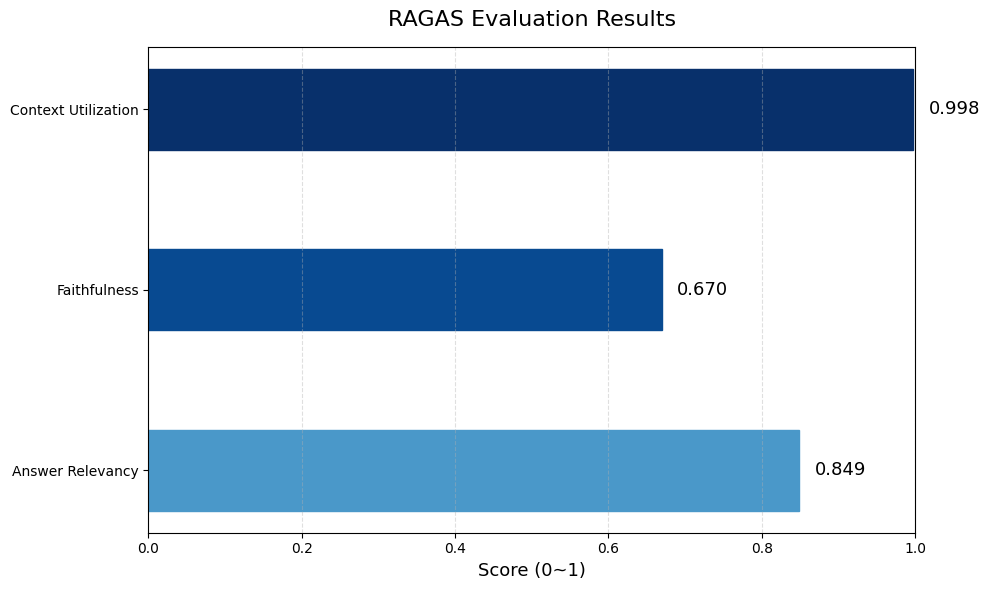

In [ ]:
import matplotlib.pyplot as plt

# RAGAS Scores (3개 버전)
scores = {
    "Answer Relevancy": 0.8492,
    "Faithfulness": 0.6698,
    "Context Utilization": 0.9975
}

labels = list(scores.keys())
values = list(scores.values())

plt.figure(figsize=(10, 6))

bars = plt.barh(labels, values, height=0.45)

# x 범위 고정 (0~1)
plt.xlim(0, 1)

# 색 조정 (선택 사항 — 자동색도 괜찮음)
for i, bar in enumerate(bars):
    bar.set_color(plt.cm.Blues(0.6 + 0.3*i))

# 값 텍스트 표시
for bar, value in zip(bars, values):
    plt.text(
        value + 0.02,
        bar.get_y() + bar.get_height()/2,
        f"{value:.3f}",
        va='center',
        fontsize=13
    )

plt.title("RAGAS Evaluation Results", fontsize=16, pad=15)
plt.xlabel("Score (0~1)", fontsize=13)

plt.grid(axis='x', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


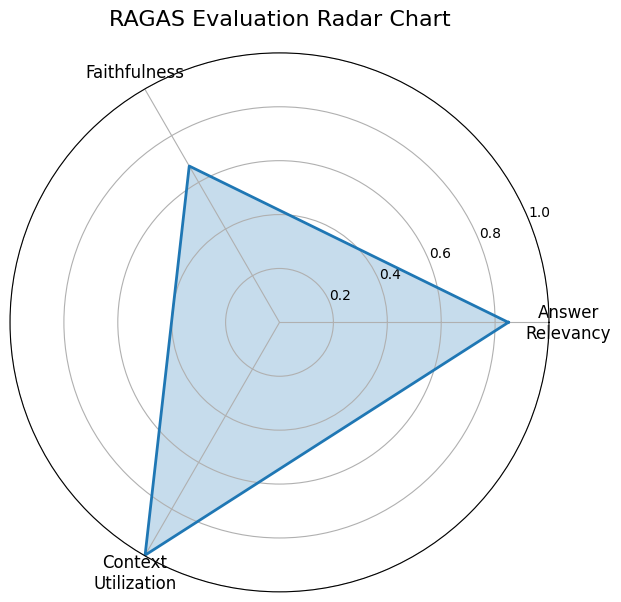

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

scores = {
    "Answer\nRelevancy": 0.8492,
    "Faithfulness": 0.6698,
    "Context\nUtilization": 0.9975
}

labels = list(scores.keys())
values = list(scores.values())

angles = np.linspace(0, 2 * np.pi, len(values), endpoint=False).tolist()
values += values[:1]  # radar wrap
angles += angles[:1]

plt.figure(figsize=(7,7), facecolor="white")

ax = plt.subplot(111, polar=True)
ax.plot(angles, values, linewidth=2)
ax.fill(angles, values, alpha=0.25)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=12)

ax.set_yticks([0.2,0.4,0.6,0.8,1.0])
ax.set_ylim(0, 1)

plt.title("RAGAS Evaluation Radar Chart", fontsize=16, pad=20)
plt.show()
